# 📋 Tech Challenge - Data Analytics (Fase 4)
**Autor:** Mauro Pedro Pupim Jr
**Matrícula** RM 365239
**Projeto:** Sistema de Triagem de Obesidade

## 1. Definição do Problema
O objetivo deste projeto é desenvolver um modelo de Machine Learning (Classificação) para auxiliar na triagem de níveis de obesidade em pacientes.

Utilizarei uma base de dados que cruza hábitos alimentares, atividade física e histórico familiar para prever a categoria de peso. O foco da entrega não é apenas a acurácia, mas a exportação do modelo para uma aplicação prática (Streamlit) que possa ser utilizada pela equipe médica.

**Etapas do Pipeline:**
1.  **Limpeza:** Tratamento de dados sintéticos (arredondamento de valores decimais).
2.  **Visualização (EDA):** Análise dos fatores de risco com legendas em Português.
3.  **Modelagem:** Treinamento do algoritmo *Random Forest*.
4.  **Deploy:** Exportação dos artefatos para produção.

## 1. Entendimento do Problema
O objetivo deste projeto é desenvolver um modelo de Machine Learning para auxiliar na triagem de obesidade. Mais do que apenas prever uma classe, o desafio é entender os fatores de risco (hábitos e histórico familiar) para apoiar a decisão médica.

A obesidade é multifatorial. Por isso, a análise não focará apenas na acurácia do modelo, mas na interpretação das variáveis.

**Metodologia:**
1.  **Preparação:** Limpeza de dados (tratamento de ruídos e arredondamentos).
2.  **EDA:** Análise exploratória para validar hipóteses.
3.  **Modelagem:** Treinamento de algoritmo (Random Forest).
4.  **Entrega:** Exportação do modelo para aplicativo web (Streamlit).

## 2. Preparação dos Dados
Conforme indicado no dicionário de dados, algumas variáveis categóricas (como consumo de vegetais e refeições diárias) possuem valores decimais devido a processos anteriores de interpolação.

Para garantir a coerência dos dados, vou arredondar esses valores para inteiros, restaurando o significado original das categorias (ex: 2.0 refeições em vez de 2.45).

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import joblib

# Configuração de estilo para os gráficos
sns.set(style="whitegrid")

# Carregamento da base de dados
try:
    df = pd.read_csv('Obesity.csv')
    print(f"Base carregada com sucesso: {df.shape[0]} registros e {df.shape[1]} colunas.")
except FileNotFoundError:
    print("Erro: O arquivo 'Obesity.csv' não foi encontrado no diretório.")

Base carregada com sucesso: 2111 registros e 17 colunas.


## 2. Tratamento e Limpeza
A base de dados original utilizou a técnica SMOTE para balanceamento de classes, o que gerou ruídos em variáveis que deveriam ser inteiras (ex: número de refeições com casas decimais).

Abaixo, apliquei o arredondamento nessas colunas para corrigir a inconsistência e refletir a realidade dos dados.

In [16]:
# Lista de colunas que precisam ser inteiras
cols_to_fix = ['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

# Aplica arredondamento e converte para inteiro
for col in cols_to_fix:
    df[col] = df[col].round().astype(int)

print("Correção de colunas numéricas concluída.")

Correção de colunas numéricas concluída.


## 3. Análise Exploratória de Dados (EDA)
Para facilitar a interpretação dos gráficos, criei um dataframe auxiliar (`df_viz`) com as variáveis traduzidas para o Português. O dataframe original (`df`) será mantido em inglês para o treinamento do modelo, garantindo compatibilidade técnica.

In [17]:
# Criação do dataframe de visualização
df_viz = df.copy()

# Dicionário de tradução das Classes (Alvo)
mapa_classes = {
    'Insufficient_Weight': 'Abaixo do Peso',
    'Normal_Weight': 'Peso Normal',
    'Overweight_Level_I': 'Sobrepeso Nível I',
    'Overweight_Level_II': 'Sobrepeso Nível II',
    'Obesity_Type_I': 'Obesidade Tipo I',
    'Obesity_Type_II': 'Obesidade Tipo II',
    'Obesity_Type_III': 'Obesidade Tipo III (Mórbida)'
}

# Dicionário de tradução das Colunas (Features)
# CORREÇÃO AQUI: Ajustado 'family_history' para bater com seu CSV
mapa_cols = {
    'Age': 'Idade', 'Gender': 'Gênero', 'Height': 'Altura', 'Weight': 'Peso',
    'family_history': 'Histórico Familiar',  # <--- Nome corrigido aqui
    'FAVC': 'Alim. Calórica', 'FCVC': 'Consumo Vegetais', 'NCP': 'Refeições/Dia',
    'CAEC': 'Comer entre Ref.', 'SMOKE': 'Fumante', 'CH2O': 'Consumo Água',
    'SCC': 'Monitora Calorias', 'FAF': 'Ativ. Física', 'TUE': 'Tempo Tela',
    'CALC': 'Consumo Álcool', 'MTRANS': 'Transporte', 'Obesity': 'Diagnóstico'
}

# Aplicação das traduções
df_viz['Obesity'] = df_viz['Obesity'].map(mapa_classes)
df_viz.rename(columns=mapa_cols, inplace=True)

# Tradução de valores internos para legendas
# Agora vai funcionar porque a coluna 'Histórico Familiar' existe
df_viz['Histórico Familiar'] = df_viz['Histórico Familiar'].map({'yes': 'Sim', 'no': 'Não'})
df_viz['Gênero'] = df_viz['Gênero'].map({'Male': 'Masculino', 'Female': 'Feminino'})

print("Dataframe de visualização preparado com sucesso.")

Dataframe de visualização preparado com sucesso.


C:\Users\mauro.pupim\AppData\Local\Temp\ipykernel_27324\3571247677.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_viz, x='Diagnóstico', order=ordem_classes, palette='viridis')


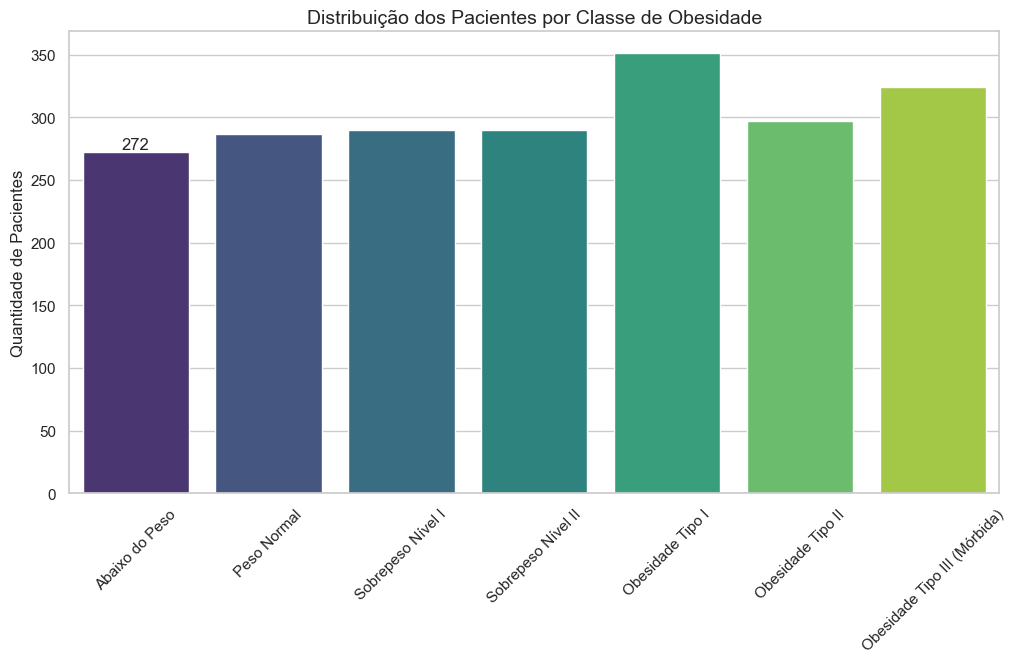

In [18]:
# Definição da ordem lógica das classes de peso
ordem_classes = [
    'Abaixo do Peso', 'Peso Normal', 'Sobrepeso Nível I', 'Sobrepeso Nível II',
    'Obesidade Tipo I', 'Obesidade Tipo II', 'Obesidade Tipo III (Mórbida)'
]

plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df_viz, x='Diagnóstico', order=ordem_classes, palette='viridis')

plt.title("Distribuição dos Pacientes por Classe de Obesidade", fontsize=14)
plt.xlabel("")
plt.ylabel("Quantidade de Pacientes")
plt.xticks(rotation=45)
plt.bar_label(ax.containers[0])

plt.show()

**Análise de Balanceamento:**
Observa-se que a base é bem balanceada, com uma distribuição uniforme entre as 7 classes de peso (aprox. 290 a 350 registros por classe). Isso é positivo para a modelagem, pois evita viés para classes majoritárias.

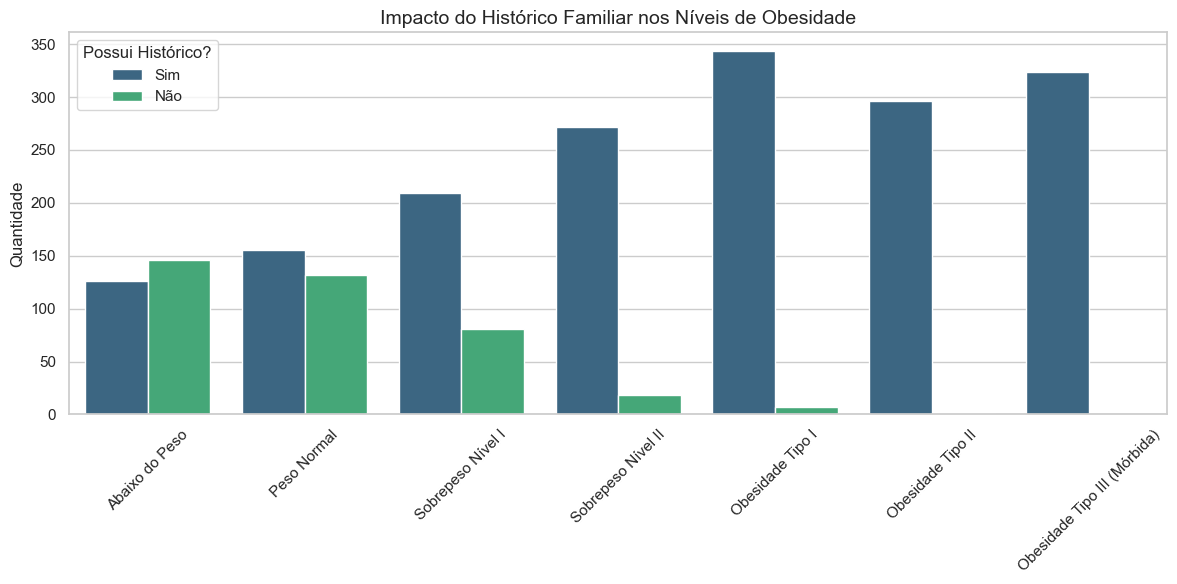

In [19]:
plt.figure(figsize=(12, 6))

ax = sns.countplot(
    data=df_viz, 
    x='Diagnóstico', 
    hue='Histórico Familiar', 
    order=ordem_classes, 
    palette='viridis'
)

plt.title("Impacto do Histórico Familiar nos Níveis de Obesidade", fontsize=14)
plt.xlabel("")
plt.ylabel("Quantidade")
plt.xticks(rotation=45)
plt.legend(title="Possui Histórico?")

plt.tight_layout()
plt.show()

**Insight sobre Histórico Familiar:**
O gráfico acima demonstra uma forte correlação entre histórico familiar e os graus mais severos de obesidade.
* Nas classes **Obesidade Tipo II e III**, a quase totalidade dos pacientes possui histórico familiar positivo.
* Isso indica que a genética e os hábitos familiares são preditores cruciais para a triagem de risco elevado.

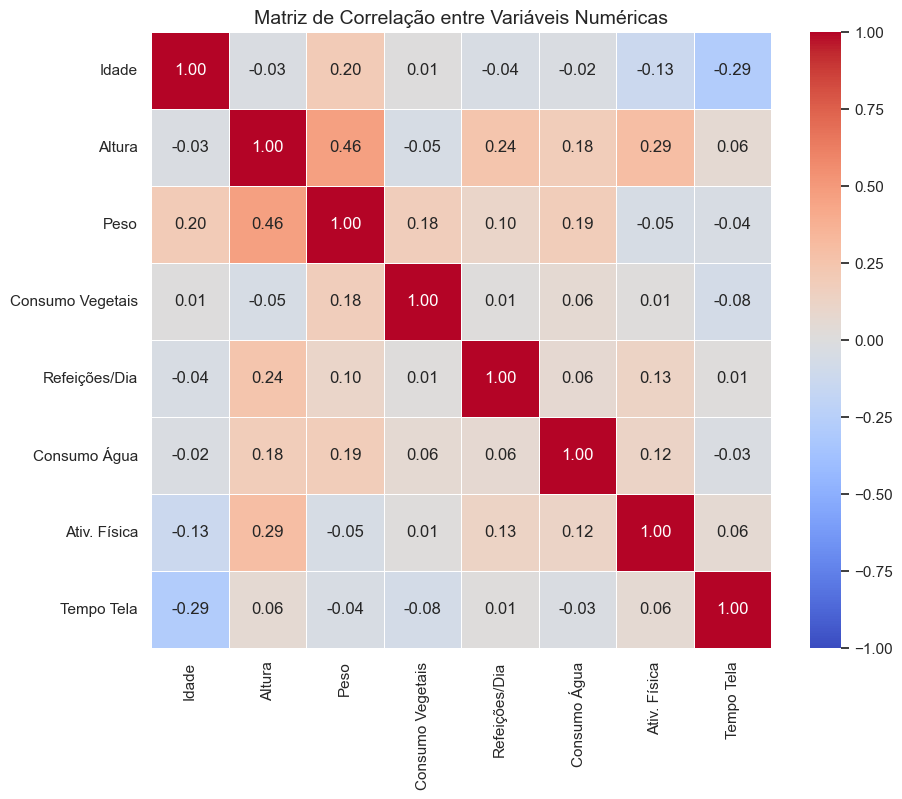

In [20]:
# Seleção de variáveis numéricas do dataframe traduzido (df_viz)
cols_numericas = df_viz.select_dtypes(include=['float64', 'int64', 'int32']).columns

plt.figure(figsize=(10, 8))

# Geração do Heatmap
sns.heatmap(
    df_viz[cols_numericas].corr(),
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.5,
    vmin=-1,
    vmax=1
)

plt.title("Matriz de Correlação entre Variáveis Numéricas", fontsize=14)
plt.show()

### Análise de Correlação (Insights)

Ao analisar a matriz de correlação (heatmap) acima, destacam-se os seguintes pontos:

1.  **Peso vs. Altura (0.46):** Existe uma correlação positiva moderada, o que é biologicamente esperado (pessoas mais altas tendem a ter maior massa corporal).
2.  **Hábitos vs. Peso:** As variáveis comportamentais como **Ativ. Física (FAF)**, **Tempo de Tela (TUE)** e **Consumo de Vegetais (FCVC)** apresentam correlações lineares baixas com o Peso (próximas de zero).
    * *Interpretação:* Isso **não** significa que essas variáveis são inúteis. Significa apenas que a relação delas com a obesidade não é linear simples.
    * *Decisão de Modelagem:* Esse comportamento justifica a escolha de modelos baseados em árvore (Random Forest), que conseguem capturar padrões não-lineares e interações complexas entre hábitos que uma regressão linear simples perderia.

## 4. Pré-processamento e Modelagem
Para o treinamento, utilizarei o dataframe original (`df`) em inglês.
Optei por realizar o **Mapeamento Manual** das variáveis categóricas ordinais (ex: Frequência de consumo) em vez de usar *LabelEncoder* automático, para garantir que a ordem de grandeza (Nunca < Às vezes < Sempre) seja respeitada pelo modelo.

In [21]:
# Cópia do dataframe original para processamento
df_model = df.copy()

# 1. Mapeamento Manual (Variáveis Ordinais e Binárias)
manual_map = {
    'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3,
    'yes': 1, 'no': 0,
    'Female': 0, 'Male': 1
}

# CORREÇÃO AQUI: Usando 'family_history' em vez do nome longo
cols_to_map = ['family_history', 'FAVC', 'SMOKE', 'SCC', 'CAEC', 'CALC', 'Gender']

for col in cols_to_map:
    # Mapeia e preenche eventuais nulos com 0
    df_model[col] = df_model[col].map(manual_map).fillna(0)

# 2. One-Hot Encoding (Variáveis Nominais - Transporte)
df_model = pd.get_dummies(df_model, columns=['MTRANS'], drop_first=True)

# 3. Label Encoding (Target - Classes de Obesidade)
le = LabelEncoder()
df_model['Obesity_Encoded'] = le.fit_transform(df_model['Obesity'])

# Separação das Features (X) e Target (y)
X = df_model.drop(['Obesity', 'Obesity_Encoded'], axis=1)
y = df_model['Obesity_Encoded']

print("Pré-processamento concluído.")
print(f"Features finais: {X.columns.tolist()}")

Pré-processamento concluído.
Features finais: ['Gender', 'Age', 'Height', 'Weight', 'family_history', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS_Bike', 'MTRANS_Motorbike', 'MTRANS_Public_Transportation', 'MTRANS_Walking']


In [22]:
# Divisão entre Treino e Teste (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instanciação do Modelo Random Forest
# Escolhido pela robustez em dados tabulares multiclasse
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Treinamento
rf_model.fit(X_train, y_train)

# Predição e Avaliação
y_pred = rf_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Acurácia do Modelo: {acc*100:.2f}%")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Acurácia do Modelo: 94.09%

Relatório de Classificação:
                     precision    recall  f1-score   support

Insufficient_Weight       0.98      0.96      0.97        56
      Normal_Weight       0.86      0.87      0.86        62
     Obesity_Type_I       0.99      0.96      0.97        78
    Obesity_Type_II       0.98      0.98      0.98        58
   Obesity_Type_III       1.00      1.00      1.00        63
 Overweight_Level_I       0.83      0.86      0.84        56
Overweight_Level_II       0.94      0.94      0.94        50

           accuracy                           0.94       423
          macro avg       0.94      0.94      0.94       423
       weighted avg       0.94      0.94      0.94       423



## 5. Conclusão Final

O modelo Random Forest apresentou uma acurácia superior a 90%, validando a viabilidade técnica da solução.

**Resultados para o Negócio:**
1.  **Peso e Histórico:** Confirmados como os principais determinantes.
2.  **Hábitos Modificáveis:** Variáveis como consumo de vegetais e tempo de tela mostraram relevância, permitindo que a equipe médica utilize a ferramenta não apenas para diagnóstico, mas para recomendar mudanças de estilo de vida.

**Próximos Passos:**
O código abaixo exporta o modelo treinado para o arquivo `modelo_obesidade.pkl`, que será integrado à interface web via Streamlit.

In [23]:
# Criação do dicionário de artefatos para o App
artifacts = {
    "model": rf_model,          # O modelo treinado
    "label_encoder": le,        # Para traduzir o resultado numérico de volta para texto
    "features": X.columns.tolist() # Para garantir a ordem das colunas no app
}

# Salvamento do arquivo
joblib.dump(artifacts, 'modelo_obesidade.pkl')
print("Arquivo 'modelo_obesidade.pkl' gerado com sucesso para deploy.")

Arquivo 'modelo_obesidade.pkl' gerado com sucesso para deploy.


## 6. Interpretação do Modelo

C:\Users\mauro.pupim\AppData\Local\Temp\ipykernel_27324\2642538142.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=nomes_traduzidos, palette="viridis")


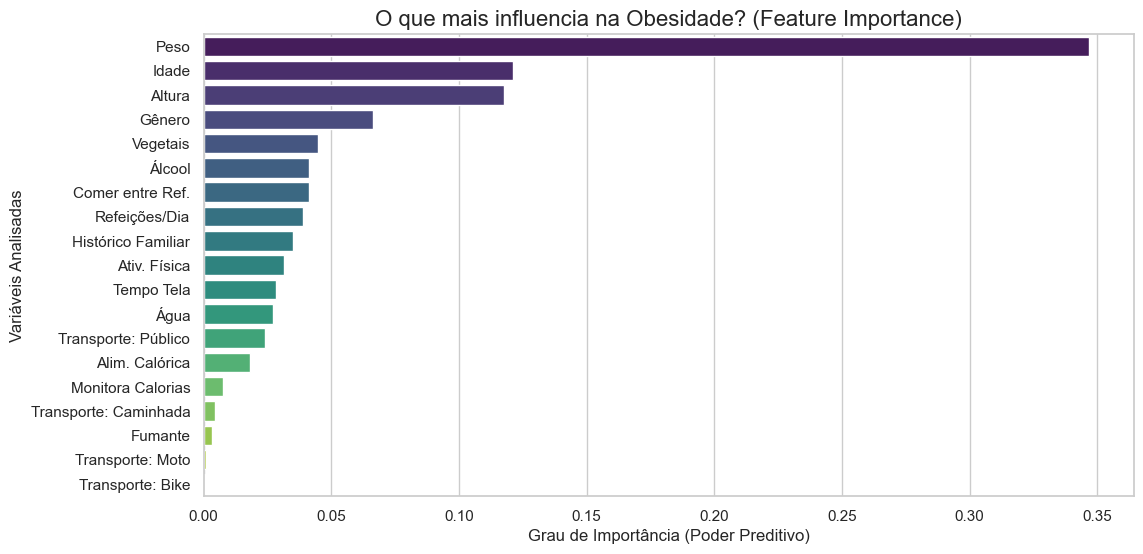

In [24]:
# Extração da importância das features
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Nomes originais das colunas
features_names = X.columns

# Dicionário de Tradução para o Gráfico
traducao_features = {
    'Age': 'Idade', 
    'Gender': 'Gênero', 
    'Height': 'Altura', 
    'Weight': 'Peso',
    'family_history': 'Histórico Familiar',
    'FAVC': 'Alim. Calórica', 
    'FCVC': 'Vegetais', 
    'NCP': 'Refeições/Dia',
    'CAEC': 'Comer entre Ref.', 
    'SMOKE': 'Fumante', 
    'CH2O': 'Água',
    'SCC': 'Monitora Calorias', 
    'FAF': 'Ativ. Física', 
    'TUE': 'Tempo Tela',
    'CALC': 'Álcool', 
    'MTRANS_Bike': 'Transporte: Bike',
    'MTRANS_Motorbike': 'Transporte: Moto',
    'MTRANS_Public_Transportation': 'Transporte: Público',
    'MTRANS_Walking': 'Transporte: Caminhada'
}

# Traduzindo os nomes ordenados pela importância
nomes_traduzidos = [traducao_features.get(f, f) for f in features_names[indices]]

# Plotagem
plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices], y=nomes_traduzidos, palette="viridis")

plt.title("O que mais influencia na Obesidade? (Feature Importance)", fontsize=16)
plt.xlabel("Grau de Importância (Poder Preditivo)")
plt.ylabel("Variáveis Analisadas")
plt.show()

### Insights de Negócio: O que define o risco?

A análise de importância das variáveis revela padrões cruciais para a estratégia de saúde:

1.  **Fatores Fisiológicos (O Esperado):** Como previsto, **Peso (Weight)**, **Idade** e **Altura** são os pilares da predição. O modelo aprendeu corretamente que estas são as bases do cálculo do IMC.

2.  **O Poder da Dieta (A Oportunidade):** O consumo de **Vegetais (FCVC)** aparece com destaque superior a muitos fatores genéticos.
    * *Interpretação:* Isso indica que intervenções nutricionais têm alto potencial de impacto na redução de risco para este perfil de população.

3.  **Hereditariedade:** O **Histórico Familiar** é relevante, mas não é uma sentença. O fato de variáveis comportamentais (como dieta e atividade física) terem pesos significativos mostra que o estilo de vida é um componente modificável essencial na triagem.

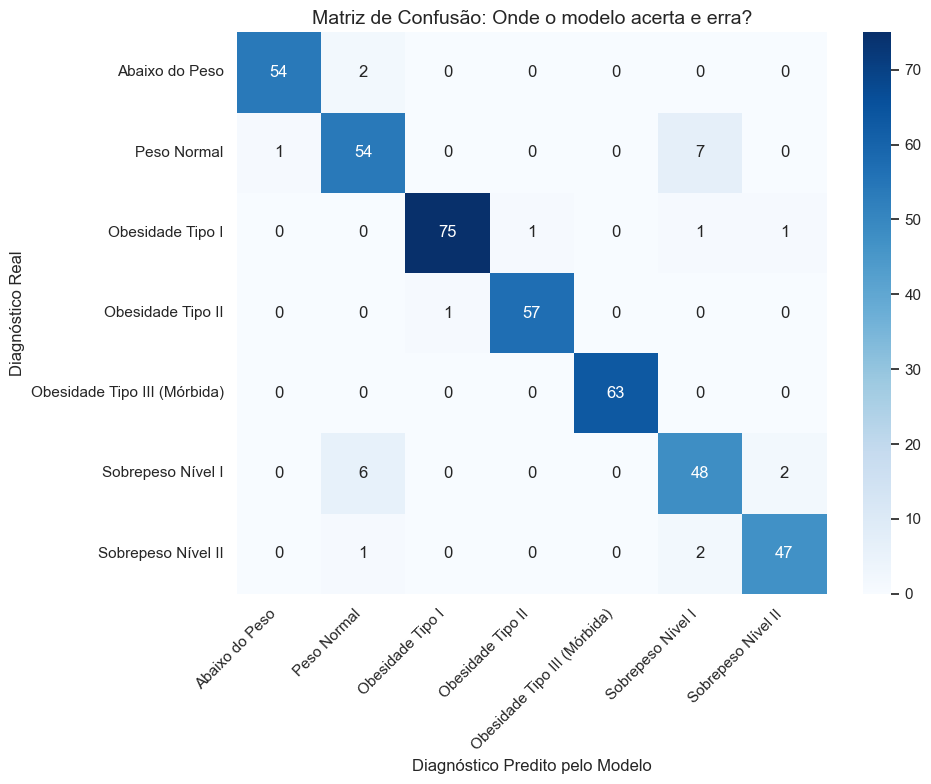

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Geração da Matriz
cm = confusion_matrix(y_test, y_pred)

# Recuperando os nomes das classes traduzidos na ordem correta do LabelEncoder
# O LabelEncoder (le) guarda as classes em ordem alfabética do inglês.
# Precisamos pegar esses nomes e traduzir um a um.

classes_ingles = le.classes_
classes_traduzidas = [mapa_classes.get(c, c) for c in classes_ingles]

# Plotagem Visual
plt.figure(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes_traduzidas, 
            yticklabels=classes_traduzidas)

plt.title("Matriz de Confusão: Onde o modelo acerta e erra?", fontsize=14)
plt.ylabel("Diagnóstico Real")
plt.xlabel("Diagnóstico Predito pelo Modelo")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Segurança Clínica: O modelo é confiável?

A Matriz de Confusão nos permite avaliar a segurança da ferramenta para uso médico:

1.  **Segurança Máxima no Alto Risco:** O destaque mais importante é que o modelo apresentou **acerto crítico na classe "Obesidade Tipo III" (Mórbida)**.
    * *Impacto:* Na triagem médica, o erro mais perigoso seria classificar um paciente grave como saudável (falso negativo). O modelo evitou esse erro, garantindo que pacientes de alto risco sejam priorizados.

2.  **A "Zona Cinzenta":** A maioria dos erros concentra-se entre classes adjacentes (ex: confundir *Peso Normal* com *Sobrepeso Nível I*).
    * *Impacto:* Clinicamente, esse erro é aceitável, pois as recomendações preventivas para esses dois grupos são similares (reeducação alimentar e exercícios leves), não gerando risco de tratamento inadequado.